In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
results_dir = "../data/results/classification/svc_balanced"
sentiment_dir = "../data/evaluationscore/"
canonization_labels_dir = "../data/labels/"
lang = "eng"

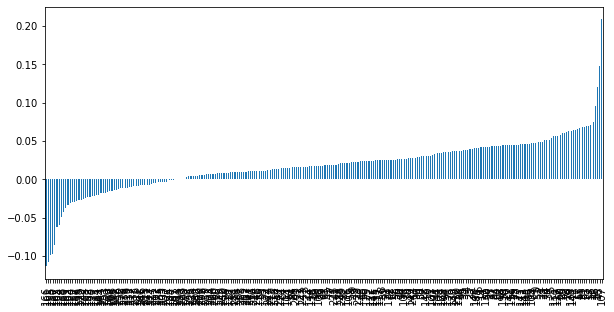

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_sentiment_scores, read_library_scores
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import random
random.seed(9)

labels = read_sentiment_scores(sentiment_dir, canonization_labels_dir, lang)
library_scores = read_library_scores(sentiment_dir, canonization_labels_dir, lang)


In [3]:
labels

,book_name,y,c
1,Austen_Jane_Pride-and-Prejudice_1813,0.029731,3
2,Austen_Jane_Sense-and-Sensibility_1811,0.049103,3
3,Barrie_J-M_Auld-Licht-Idylls_1888,0.016107,3
4,Barrie_J-M_Sentimental-Tommy_1896,0.038327,3
5,Beerbohm_Max_Zuleika-Dobson_1911,0.053656,3
...,...,...,...
148,Wollstonecraft_Mary_Mary_1788,0.040233,3
170,Scott_Walter_The-Black-Dwarf_1816,-0.021840,2
177,Beckford_William_Vathek_1786,0.006286,2
234,Radcliffe_Ann_Udolpho_1794,0.004301,2


<AxesSubplot:>

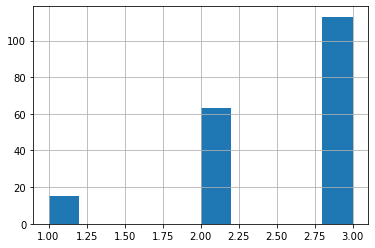

In [4]:
labels["c"].hist()

In [5]:
3 in labels["c"].values

True

191


<AxesSubplot:ylabel='Frequency'>

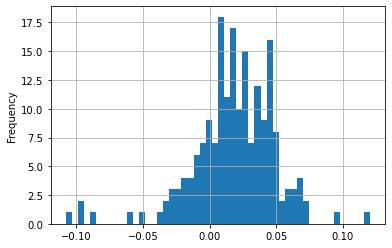

In [6]:
## Labels statistics
print(len(pd.unique(labels["book_name"]))) #197
# 254 labels, 197 different book_names -> 57 second/third... reviews
# 36 book_names with more than 1 label, these 36 book_names have 93 labels
# 93 = 36 first reviews + 57 second/third... reviews
# 6 texts have opposing reviews (13 reviews are opposing)
# 191 texts after aggregating (without opposing reviews)

labels["y"].plot.hist(grid=True, bins=50)

In [7]:
class Regression(object):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95"]) or (dimensionality_reduction is None)
        self._check_class_specific_assertions()
        
        self.language = language
        self.features = features
        self.labels = labels
        self.labels = self._prepare_labels()
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        if self.drop_columns_including:
            self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
            
    def _check_class_specific_assertions(self):
        assert model in ["xgboost", "svr", "lasso"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
    
    def _prepare_labels(self):
        return self.labels.drop(columns="c")

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param, train_X=None, train_y=None, train_book_names=None, task_type=None):
        if self.model == "xgboost":
            if task_type == "binary_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
            elif task_type == "multiclass_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
            elif task_type == "regression":
                is_classification = False
            else:
                raise Exception("Not a valid task_type")
            
            def feval(preds, train_data):
                labels = train_data.get_label()
                if is_classification:
                    labels = labels.astype(int)
                    preds = preds.argmax(axis=1).astype(int)
                    if task_type == "binary_classification":
                        return 'acc', accuracy_score(labels, preds)
                    elif task_type == "multiclass_classification":
                        return 'f1', f1_score(labels, preds, average='macro')
                else:
                    return 'rmse', np.sqrt(mean_squared_error(labels, preds))
            
            if is_classification:
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
            else:
                dtrain = xgboost.DMatrix(train_X, label=train_y)
            results = []
            df = np.hstack((train_book_names, train_X))
            df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(train_X.shape[1])])
            for max_depth in [2, 4, 6, 8]:
                for learning_rate in [None, 0.01, 0.033, 0.1]:
                    for colsample_bytree in [0.33, 0.60, 0.75]:
                        if task_type == "multiclass_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"}
                        elif task_type == "binary_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"}
                        elif task_type == "regression":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1}
                        else:
                            raise Exception("Not a valid task_type")
                        cv_results = xgboost.cv(
                                        params,
                                        dtrain,
                                        num_boost_round=99999,
                                        seed=42,
                                        nfold=5,
                                        folds=self._split_booknames(df, 5, return_indices=True),
                                        feval=feval,
                                        maximize=is_classification, # if classification, maximize f1/acc score.
                                        early_stopping_rounds=10,
                                        verbose_eval=False)

                        if task_type == "binary_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-acc-mean"]
                        elif task_type == "multiclass_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-f1-mean"]
                        elif task_type == "regression":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-rmse-mean"]
                        else:
                            raise Exception("Not a valid task_type")
                        num_boost_round = len(cv_results)
                        if task_type == "multiclass_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"})
                        elif task_type == "binary_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"})
                        elif task_type == "regression":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score})
                        else:
                            raise Exception("Not a valid task_type")
            best_parameters = sorted(results, key=lambda x: x["nested_cv_score"], reverse=is_classification)[0]
            return best_parameters
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "svc":
            print("SVC with balanced class weight")
            return SVC(C=model_param, class_weight="balanced")
        
    def _split_booknames(self, df, nr_splits, return_indices=False):
        """
        Distribute book names over splits.
        All works of an author are in the same split.
        """
        book_names = df["book_name"].unique()
        authors = []
        booknames_authors_mapping = {}

        #Get authors
        for book_name in book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in booknames_authors_mapping:
                booknames_authors_mapping[author].append(book_name)
            else:
                booknames_authors_mapping[author] = []
                booknames_authors_mapping[author].append(book_name)
        #Distribute authors over splits so that each split has approximately the same number of books
        works_per_author = Counter(authors)
        goal_sum = round(len(book_names)/nr_splits)
        tolerance = 0.03
        lower_threshold = goal_sum - round(tolerance*goal_sum)
        upper_threshold = goal_sum + round(tolerance*goal_sum)
        author_splits = []
        popped_dict = {}

        for i in range (0, nr_splits-1):
            works_in_split = 0
            split = []
            curr_author_workcount = 0

            # take values from popped dict first
            if bool(popped_dict):  
                popped = []
                for curr_author, curr_author_workcount in popped_dict.items():
                    # leave item in popped dict if value is too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        continue
                    else:
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                for current_author in popped:
                    del popped_dict[current_author]
            while works_in_split < upper_threshold:
                if bool(works_per_author):
                    curr_author = random.choice(list(works_per_author.keys()))
                    curr_author_workcount = works_per_author.pop(curr_author)
                    # Put values into separate dict if too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        popped_dict[curr_author] = curr_author_workcount
                    else:
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                else:
                    #ignore upper threshold
                    popped = []
                    for curr_author, curr_author_workcount in popped_dict.items():
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                    for current_author in popped:
                        del popped_dict[current_author]

            author_splits.append(split)
        #Create last split directly from remaining dict
        works_in_last_split = sum(works_per_author.values()) + sum(popped_dict.values())
        split = list(works_per_author.keys()) + list(popped_dict.keys())
        author_splits.append(split)

        if not return_indices:
            #Map author splits to book names
            book_splits = []
            for author_split in author_splits:
                book_split = []
                for author in author_split:
                    book_split.extend(booknames_authors_mapping[author])
                book_splits.append(book_split)
        else:
            book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(book_names))
            book_splits = []
            for author_split in author_splits:
                test_split = []
                for author in author_split:
                    test_split.extend([book_name_idx_mapping[book_name] for book_name in booknames_authors_mapping[author]])
                train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
                book_splits.append((train_split, test_split))
        return book_splits
    
    def _get_pvalue(self, validation_corr_pvalues):
        # Harmonic mean p-value
        denominator = sum([1/x for x in validation_corr_pvalues])
        mean_p_value = len(validation_corr_pvalues)/denominator
        return mean_p_value
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        df = df.merge(right=self.labels, on="book_name", how="inner", validate="many_to_one")
        return df
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="regression")
                dtrain = xgboost.DMatrix(train_X, label=train_y)
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
                
                print("train preds:", model.predict(xgboost.DMatrix(train_X)))
                print("validation preds:", model.predict(xgboost.DMatrix(validation_X)))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}, ValCorr: {np.round(validation_corr, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        pd.concat(all_validation_books).to_csv(results_dir + "/y-yhat-" + self.language + "-" + ".csv", index=False)
        
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""TrainMSE: {np.round(mean_train_mse, 3)}, TrainRMSE: {np.round(mean_train_rmse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, TrainR2: {np.round(mean_train_r2, 3)}, TrainCorr: {np.round(mean_train_corr, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}, ValCorr: {np.round(mean_validation_corr, 3)}, ValCorrPValue: {np.round(mean_p_value, 3)}""")
            print("\n---------------------------------------------------\n")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.ylim([0,1])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + "-" + self.model + "-" + str(self.dimensionality_reduction) 
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + ".png", 
            dpi=400, bbox_inches="tight")
    
            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value


In [8]:
'''
Classification into reviewed/not reviewed
'''

class TwoclassClassification(Regression):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc", "xgboost"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        
    def _prepare_labels(self):
        labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
        return labels
        
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        agg_labels = self.labels[["book_name"]].drop_duplicates()
        agg_labels["y"] = 1
        df = df.merge(right=agg_labels, on="book_name", how="left", validate="many_to_one")
        df["y"] = df["y"].fillna(value=0)
        #Select books written after year of first review)
        year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
        df = df.loc[year>=min(year)]
        return df
    
    def _get_sample_weights(self, df):
        # Weights for calculating accuracy 
        chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
        chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
        chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
        df = df.merge(right=chunks_per_book, how="left", on="book_name")
        sample_weights = df["chunks_per_book"].tolist()
        return sample_weights
    
    def _aggregate_chunk_predictions(self, df):
        g = df.groupby("book_name")
        
        # Majority vote
        # If one value is more common, assign it to every chunk
        # Therefore, accuracy is either 0 or 1
        # If both values are equally likely, leave them unchanged, and accuracy is 0.5
        def _get_mode_accuracy(group):
            counts = group["yhat"].value_counts()
            if len(counts) == 1:
                mode_acc = counts.index[0]
            else:
                mode_acc = 0.5
            return mode_acc
        mode_accs = g.apply(_get_mode_accuracy).rename("mode_acc").reset_index()
        mode_acc = mode_accs["mode_acc"].mean()
        
        # Average accuracy within book
        book_acc = g.apply(lambda group: accuracy_score(group["y"], group["yhat"])).mean()
        #Accuracy when each chunk is treated as single document
        chunk_acc = accuracy_score(df["y"], df["yhat"])#, sample_weight = self._get_sample_weights(df))
        return {"mode_acc": mode_acc, "book_acc": book_acc, "chunk_acc": chunk_acc}
    
    def _split_booknames_stratified(self, df, nr_splits, return_indices=False):
        label_splits = []
        combined_splits = []
        # Split df into folds for each label individualls
        df_by_labels = df.groupby("y")
        for name, group in df_by_labels:
            split = self._split_booknames(group, 5)
            label_splits.append(split)
        # Combine splits so that one splits combines splits for all labels
        for fold in range(0, nr_splits):
            combined_split = []
            for label in range(0, len(pd.unique(df["y"]))):
                label_split = label_splits[label]
                fold_split = label_split[fold]
                combined_split.extend(fold_split)
            combined_splits.append(combined_split)
        return combined_splits                            
                             
    def run(self):
        train_accs = []
        validation_accs = []
        df = self.df
        df = self._combine_df_labels(df)
        book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
        all_validation_books = []

        for index, split in enumerate(book_names_split_stratified):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="binary_classification")
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)

            train_acc = self._aggregate_chunk_predictions(train_books)
            validation_acc = self._aggregate_chunk_predictions(validation_books)
            
            all_validation_books.append(validation_books)
            
            train_accs.append(train_acc)
            validation_accs.append(validation_acc)
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

        train_accs = pd.DataFrame(train_accs)
        validation_accs = pd.DataFrame(validation_accs)

        mean_train_mode_acc = train_accs["mode_acc"].mean()
        mean_train_book_acc = train_accs["book_acc"].mean()
        mean_train_chunk_acc = train_accs["chunk_acc"].mean()
        mean_validation_mode_acc = validation_accs["mode_acc"].mean()
        mean_validation_book_acc = validation_accs["book_acc"].mean()
        mean_validation_chunk_acc = validation_accs["chunk_acc"].mean()
        print('validation mode, book, and chunk acc', mean_validation_mode_acc, mean_validation_book_acc, mean_validation_chunk_acc)

        return mean_train_book_acc, mean_validation_book_acc

In [9]:
# ''' 
# Classification into in library/not in library
# '''

# class LibraryClassification(TwoclassClassification):
#     def _prepare_labels(self):
#         return self.labels

In [10]:
'''
Classification into not reviewed/negative/not classified/positive
'''

class MulticlassClassification(TwoclassClassification):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc", "xgboost"]
        assert features in ["book", "book_and_averaged_chunk"]#, "chunk_and_copied_book", "chunk"]
                
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        df = df.merge(right=self.labels, on="book_name", how="left", validate="many_to_one")
        df["y"] = df["y"].fillna(value=0)
        #Select books written after year of first review
        year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
        df = df.loc[year>=min(year)]
        return df
    
    def _evaluate_predictions(self, df):
        score = f1_score(df["y"], df["yhat"], average='macro')
        return score
            
        
    def run(self):
        train_f1s = []
        validation_f1s = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
        all_validation_books = []

        for index, split in enumerate(book_names_split_stratified):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            print("class distribution over dfs")
            print(train_df["y"].value_counts())
            print(validation_df["y"].value_counts())
            #print(train_df.loc[train_df["y"]==1])
            print(validation_df.loc[validation_df["y"]==1])
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="multiclass_classification")
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_f1 = self._evaluate_predictions(train_books)
            validation_f1 = self._evaluate_predictions(validation_books)
            all_validation_books.append(validation_books)
            
            train_f1s.append(train_f1)
            validation_f1s.append(validation_f1)
            if self.verbose:
                print(f"Fold: {index+1}, TrainF1: {np.round(train_f1, 3)}, ValF1: {np.round(validation_f1, 3)}")
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

        mean_train_f1 = statistics.mean(train_f1s)
        mean_validation_f1 = statistics.mean(validation_f1s)
        
        if self.verbose:
            print(f"""TrainF1: {np.round(mean_train_f1, 3)}, ValidationF1: {np.round(mean_validation_f1, 3)}""")
            print("\n---------------------------------------------------\n")
        return mean_train_f1, mean_validation_f1

In [11]:
### Cross-validation

# Feature split
complexity_features = []

# All parameters
models = ["svr", "lasso", "xgboost", "svc"]
model_params = {"svr": [1], "lasso": [1, 4], "xgboost": [None], "svc": [0.1, 1, 10, 100, 1000, 10000]} #
dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', [None]]
features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

# Which parameters to use
regression_params = {"model": ["xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], "features": features}
testing_params = {"model": models[3], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book"]}
twoclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book", "book_and_averaged_chunk"]}
multiclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1],
                     "features": ["book", "book_and_averaged_chunk"]}

book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
book_df = drop_default_columns(book_df, drop_default_columns_including)
book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)

print(len(book_df.columns), len(book_and_averaged_chunk_df.columns),len(chunk_df.columns),len(chunk_and_copied_book_df.columns),)

len(list(book_and_averaged_chunk_df.columns))

for i in list(book_and_averaged_chunk_df.columns):
    print(i)

In [12]:
'''
Run two-class classification
'''
results = []
param_dict = "twoclass" #"twoclass"
for lang in [lang]:
    if param_dict == "testing":
        param_dir = testing_params
    elif param_dict == "twoclass":
        param_dir = twoclass_params
    elif param_dict == "multiclass":
        param_dir = multiclass_params
    elif param_dict == "full_cv":
        param_dir = full_cv_params
    elif param_dict == "language_specific":
        if lang == "eng":
            param_dir = eng_params
        else: 
            param_dir = ger_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

    for model in [] + param_dir['model']:
        print(model)
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in param_dir["dimensionality_reduction"]:
                for features in param_dir["features"]:
                    for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
                        print(param_dict, lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
                        experiment = TwoclassClassification(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction=dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        mean_train_book_acc, mean_validation_book_acc = experiment.run()
                        results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_book_acc, mean_validation_book_acc))
                        print(param_dict, lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param, mean_train_book_acc, mean_validation_book_acc)
results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
"dimensionality_reduction", "model_param", "mean_train_book_acc", "mean_validation_book_acc"])
results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)


svc
twoclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 0.1
Dropped 300 columns.
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
[[129 286]
 [  4 187]]
Predicted  0.0  1.0  All
True                    
0.0        129  286  415
1.0          4  187  191
All        133  473  606
validation mode, book, and chunk acc 0.7818134815458133 0.5201363141843645 0.5201363141843645
twoclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 0.1 0.5337123272734315 0.5201363141843645
twoclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 0.1
Dropped 330 columns.
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
[[131 284]

SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
[[106 309]
 [ 27 164]]
Predicted  0.0  1.0  All
True                    
0.0        106  309  415
1.0         27  164  191
All        133  473  606
validation mode, book, and chunk acc 0.7802127976433696 0.4448373337248208 0.4448373337248208
twoclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 1 0.5221992014023874 0.4448373337248208
twoclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1
Dropped 1198 columns.
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
[[112 303]
 [ 21 170]]
Predicted  0.0  1.0  All
True                    
0.0        112  303  415
1.0         21  170  191
All        133  473  606

SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
[[228 187]
 [ 32 159]]
Predicted  0.0  1.0  All
True                    
0.0        228  187  415
1.0         32  159  191
All        260  346  606
validation mode, book, and chunk acc 0.5698517238584792 0.63965867254793 0.63965867254793
twoclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 100 0.7005791888202315 0.63965867254793
twoclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 100
Dropped 330 columns.
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
[[226 189]
 [ 30 161]]
Predicted  0.0  1.0  All
True                    
0.0        226  189  415
1.0         30  161  191
All        256  350  606
validation mode, book, and chunk acc 0.5

SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
[[187 228]
 [ 43 148]]
Predicted  0.0  1.0  All
True                    
0.0        187  228  415
1.0         43  148  191
All        230  376  606
validation mode, book, and chunk acc 0.6223763690613142 0.5522219787523875 0.5522219787523875
twoclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 1000 0.5589836498127738 0.5522219787523875
twoclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1000
Dropped 1198 columns.
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
SVC with balanced class weight
[[143 272]
 [ 44 147]]
Predicted  0.0  1.0  All
True                    
0.0        143  272  415
1.0         44  147  191
All        187  41

[[290 125]
 [ 74 117]]
Predicted  0.0  1.0  All
True                    
0.0        290  125  415
1.0         74  117  191
All        364  242  606
validation mode, book, and chunk acc 0.3986499376329885 0.6689274168835485 0.6689274168835485
twoclass eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None 0.9129303014149871 0.6689274168835485
twoclass eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None
Dropped 330 columns.
[[291 124]
 [ 74 117]]
Predicted  0.0  1.0  All
True                    
0.0        291  124  415
1.0         74  117  191
All        365  241  606
validation mode, book, and chunk acc 0.3944604403119766 0.6738699332028436 0.6738699332028436
twoclass eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None 0.8575422759943929 0.6738699332028436
twoclass eng xgboost book ['average_sentence

In [13]:
'''
Run Multiclass Classification
'''
results = []
param_dict = "multiclass" 
for lang in [lang]:    
    if param_dict == "testing":
        param_dir = testing_params
        model_params = {"svr": [1], "lasso": [1], "xgboost": [None], "svc": [1]} 
    elif param_dict == "multiclass":
        param_dir = multiclass_params
    elif param_dict == "full_cv":
        param_dir = full_cv_params
    elif param_dict == "language_specific":
        if lang == "eng":
            param_dir = eng_params
        else: 
            param_dir = ger_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    #chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    #chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
    for model in [] + param_dir['model']:
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in param_dir["dimensionality_reduction"]:
                for features in param_dir["features"]:
                    for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
                                                #try:
                        print(param_dict, lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
                        experiment = MulticlassClassification(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction=dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        mean_train_f1, mean_validation_f1 = experiment.run()
                        results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_f1, mean_validation_f1))
                        print(param_dict, lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param, mean_train_f1, mean_validation_f1)
results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
"dimensionality_reduction", "model_param", "mean_train_f1", "mean_validation_f1"])
results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)

multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 0.1
Dropped 300 columns.
class distribution over dfs
0.0    333
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
121  LeFanu_Joseph-Sheridan_Uncle-Silas_1864                        8.677397   
314       Hardy_Thomas_Jude-the-Obscure_1894                        7.543836   
569  Carleton_William_The-Black-Prophet_1847                        8.484175   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
121                      0.398049                  10.889957   
314                      0.408386                   9.644512   
569                      0.400580                  11.800935   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
121                 0.484537               0.022222

                                        book_name  \
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   
281             Gissing_George_The-Odd-Women_1893   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   
281                        7.823475                      0.412498   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   
281                   9.966925                 0.507456   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
226               0.000000             0.000000               7.853800   
254               0.000000             0.000000               7.853800   
281               0.038462             0.057692    

                                           book_name  \
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
226                      Bronte_Anne_Agnes-Grey_1847   
254     Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
220                        9.691407                      0.487271   
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
220                  10.992728                 0.552008   
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
220                    0.0             0.139535                7.30049   
226                    0.0             0.000000                7.85380   
254                    0.0             

Fold: 2, TrainF1: 0.142, ValF1: 0.091
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                        book_name  \
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   
569       Carleton_William_The-Black-Prophet_1847   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   
569                        8.484175                      0.400580   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   
569                  11.800935                 0.559753   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
226  

Fold: 2, TrainF1: 0.182, ValF1: 0.142
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                       book_name  \
190     Ainsworth_William-Harrison_Rookwood_1834   
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   
318             Blackmore_R-D_Clara-Vaughan_1864   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
190                        9.573162                      0.464974   
288                        8.272039                      0.395909   
318                        9.131605                      0.421754   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
190                  11.619598                 0.551082   
288                  10.555230                 0.510809   
318                  11.606965                 0.534792   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
190      

SVC with balanced class weight
Fold: 2, TrainF1: 0.102, ValF1: 0.108
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
121  LeFanu_Joseph-Sheridan_Uncle-Silas_1864                        8.677397   
379   Carroll_Lewis_Alice-in-Wonderland_1865                        9.627620   
569  Carleton_William_The-Black-Prophet_1847                        8.484175   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
121                      0.398049                  10.889957   
379                      0.398135                  13.948234   
569                      0.400580                  11.800935   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
121                 0.484537               0.022222             0.066667   
379                 0.534852               0.

Fold: 2, TrainF1: 0.151, ValF1: 0.206
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                    book_name  doc2vec_intra_textual_variance  \
187          Lawrence_D-H_The-Trespasser_1912                        7.771897   
190  Ainsworth_William-Harrison_Rookwood_1834                        9.573162   
240       Lawrence_D-H_The-White-Peacock_1911                        7.947307   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
187                      0.435654                  10.296803   
190                      0.464974                  11.619598   
240                      0.401962                  10.703416   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
187                 0.557729               0.033333             0.133333   
190                 0.551082               0.142857             0.265306

Fold: 1, TrainF1: 0.151, ValF1: 0.079
class distribution over dfs
0.0    331
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    84
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                     book_name  \
121    LeFanu_Joseph-Sheridan_Uncle-Silas_1864   
281          Gissing_George_The-Odd-Women_1893   
567  Nesbit_Edith_The-Story-of-the-Amulet_1906   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
121                        8.677397                      0.398049   
281                        7.823475                      0.412498   
567                        8.030508                      0.386059   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
121                  10.889957                 0.484537   
281                   9.966925                 0.507456   
567                  10.429495                 0.505101   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
121              

class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                        book_name  \
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   
569       Carleton_William_The-Black-Prophet_1847   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   
569                        8.484175                      0.400580   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   
569                  11.800935                 0.559753   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
226                    0.0             0.00

class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
190         Ainsworth_William-Harrison_Rookwood_1834   
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
281                Gissing_George_The-Odd-Women_1893   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
190                        9.573162                      0.464974   
220                        9.691407                      0.487271   
281                        7.823475                      0.412498   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
190                  11.619598                 0.551082   
220                  10.992728                 0.552008   
281                   9.966925                 0.507456   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
190               0.142857     

SVC with balanced class weight
Fold: 5, TrainF1: 0.249, ValF1: 0.174
[[163  65 137  50]
 [  1   1  12   1]
 [  1  23  32   7]
 [  6  38  59  10]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        163   65  137   50  415
1.0          1    1   12    1   15
2.0          1   23   32    7   63
3.0          6   38   59   10  113
All        171  127  240   68  606
TrainF1: 0.256, ValidationF1: 0.204

---------------------------------------------------

multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 1 0.2561151195332346 0.20423082043002205
multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1
Dropped 330 columns.
class distribution over dfs
0.0    332
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    83
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                        book_name  \
226         

Fold: 4, TrainF1: 0.222, ValF1: 0.193
class distribution over dfs
0.0    330
3.0     89
2.0     52
1.0     12
Name: y, dtype: int64
0.0    85
3.0    24
2.0    11
1.0     3
Name: y, dtype: int64
                                           book_name  \
121          LeFanu_Joseph-Sheridan_Uncle-Silas_1864   
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
318                 Blackmore_R-D_Clara-Vaughan_1864   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
121                        8.677397                      0.398049   
220                        9.691407                      0.487271   
318                        9.131605                      0.421754   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
121                  10.889957                 0.484537   
220                  10.992728                 0.552008   
318                  11.606965                 0.534792   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2

Fold: 4, TrainF1: 0.284, ValF1: 0.159
class distribution over dfs
0.0    326
3.0     90
2.0     52
1.0     12
Name: y, dtype: int64
0.0    89
3.0    23
2.0    11
1.0     3
Name: y, dtype: int64
                                        book_name  \
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   
281             Gissing_George_The-Odd-Women_1893   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   
281                        7.823475                      0.412498   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   
281                   9.966925                 0.507456   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
226  

Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        165  132   53   65  415
1.0          1    6    4    4   15
2.0          2   33    9   19   63
3.0         13   48   30   22  113
All        181  219   96  110  606
TrainF1: 0.259, ValidationF1: 0.21

---------------------------------------------------

multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 1 0.25904033265265525 0.20991582851885712
multiclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 1
Dropped 1168 columns.
class distribution over dfs
0.0    333
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                    book_name  doc2vec_intra_textual_variance  \
121   LeFanu_Joseph-Sheridan_Uncle-Silas_1864                        8.677397   
190  Ainsworth_William

Fold: 4, TrainF1: 0.179, ValF1: 0.088
class distribution over dfs
0.0    331
3.0     89
2.0     52
1.0     12
Name: y, dtype: int64
0.0    84
3.0    24
2.0    11
1.0     3
Name: y, dtype: int64
                                           book_name  \
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
379           Carroll_Lewis_Alice-in-Wonderland_1865   
569          Carleton_William_The-Black-Prophet_1847   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
220                        9.691407                      0.487271   
379                        9.627620                      0.398135   
569                        8.484175                      0.400580   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
220                  10.992728                 0.552008   
379                  13.948234                 0.534852   
569                  11.800935                 0.559753   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2

SVC with balanced class weight
Fold: 3, TrainF1: 0.208, ValF1: 0.171
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
121  LeFanu_Joseph-Sheridan_Uncle-Silas_1864                        8.677397   
314       Hardy_Thomas_Jude-the-Obscure_1894                        7.543836   
379   Carroll_Lewis_Alice-in-Wonderland_1865                        9.627620   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
121                      0.398049                  10.889957   
314                      0.408386                   9.644512   
379                      0.398135                  13.948234   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
121                 0.484537               0.022222             0.066667   
314                 0.490497               0.

Fold: 2, TrainF1: 0.257, ValF1: 0.166
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
307                   Grand_Sarah_The-Beth-Book_1897   
318                 Blackmore_R-D_Clara-Vaughan_1864   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
220                        9.691407                      0.487271   
307                        8.648926                      0.460882   
318                        9.131605                      0.421754   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
220                  10.992728                 0.552008   
307                  10.721131                 0.553154   
318                  11.606965                 0.534792   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2

Fold: 2, TrainF1: 0.238, ValF1: 0.238
class distribution over dfs
0.0    333
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                        book_name  \
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   
307                Grand_Sarah_The-Beth-Book_1897   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   
307                        8.648926                      0.460882   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   
307                  10.721131                 0.553154   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
226  

Fold: 2, TrainF1: 0.276, ValF1: 0.242
class distribution over dfs
0.0    330
3.0     89
2.0     50
1.0     12
Name: y, dtype: int64
0.0    85
3.0    24
2.0    13
1.0     3
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
121  LeFanu_Joseph-Sheridan_Uncle-Silas_1864                        8.677397   
307           Grand_Sarah_The-Beth-Book_1897                        8.648926   
314       Hardy_Thomas_Jude-the-Obscure_1894                        7.543836   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
121                      0.398049                  10.889957   
307                      0.460882                  10.721131   
314                      0.408386                   9.644512   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
121                 0.484537               0.022222             0.066667   
307                 0.553154               0.000000             0.132353   


Fold: 1, TrainF1: 0.249, ValF1: 0.229
class distribution over dfs
0.0    331
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    84
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
314               Hardy_Thomas_Jude-the-Obscure_1894   
567        Nesbit_Edith_The-Story-of-the-Amulet_1906   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
220                        9.691407                      0.487271   
314                        7.543836                      0.408386   
567                        8.030508                      0.386059   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
220                  10.992728                 0.552008   
314                   9.644512                 0.490497   
567                  10.429495                 0.505101   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2

0.0    83
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                               book_name  doc2vec_intra_textual_variance  \
187     Lawrence_D-H_The-Trespasser_1912                        7.771897   
240  Lawrence_D-H_The-White-Peacock_1911                        7.947307   
281    Gissing_George_The-Odd-Women_1893                        7.823475   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
187                      0.435654                  10.296803   
240                      0.401962                  10.703416   
281                      0.412498                   9.966925   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
187                 0.557729               0.033333             0.133333   
240                 0.517143               0.020833             0.145833   
281                 0.507456               0.038462             0.057692   

     outlier_score_doc2vec  outlier_score_sbert  \
187               6.

Fold: 2, TrainF1: 0.333, ValF1: 0.243
class distribution over dfs
0.0    333
3.0     89
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    24
2.0    13
1.0     3
Name: y, dtype: int64
                                       book_name  \
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   
314           Hardy_Thomas_Jude-the-Obscure_1894   
318             Blackmore_R-D_Clara-Vaughan_1864   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
288                        8.272039                      0.395909   
314                        7.543836                      0.408386   
318                        9.131605                      0.421754   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
288                  10.555230                 0.510809   
314                   9.644512                 0.490497   
318                  11.606965                 0.534792   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
288      

SVC with balanced class weight
Fold: 2, TrainF1: 0.239, ValF1: 0.156
class distribution over dfs
0.0    332
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    83
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                     book_name  \
121    LeFanu_Joseph-Sheridan_Uncle-Silas_1864   
567  Nesbit_Edith_The-Story-of-the-Amulet_1906   
569    Carleton_William_The-Black-Prophet_1847   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
121                        8.677397                      0.398049   
567                        8.030508                      0.386059   
569                        8.484175                      0.400580   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
121                  10.889957                 0.484537   
567                  10.429495                 0.505101   
569                  11.800935                 0.559753   

     overlap_score_doc2vec  overlap_score_sbert  outlier_sco

SVC with balanced class weight
Fold: 2, TrainF1: 0.262, ValF1: 0.164
class distribution over dfs
0.0    331
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    84
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
121  LeFanu_Joseph-Sheridan_Uncle-Silas_1864                        8.677397   
281        Gissing_George_The-Odd-Women_1893                        7.823475   
379   Carroll_Lewis_Alice-in-Wonderland_1865                        9.627620   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
121                      0.398049                  10.889957   
281                      0.412498                   9.966925   
379                      0.398135                  13.948234   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
121                 0.484537               0.022222             0.066667   
281                 0.507456               0.

Fold: 1, TrainF1: 0.281, ValF1: 0.203
class distribution over dfs
0.0    334
3.0     89
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    24
2.0    13
1.0     3
Name: y, dtype: int64
                                       book_name  \
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   
318             Blackmore_R-D_Clara-Vaughan_1864   
379       Carroll_Lewis_Alice-in-Wonderland_1865   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
288                        8.272039                      0.395909   
318                        9.131605                      0.421754   
379                        9.627620                      0.398135   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
288                  10.555230                 0.510809   
318                  11.606965                 0.534792   
379                  13.948234                 0.534852   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
288      

Fold: 1, TrainF1: 0.227, ValF1: 0.129
class distribution over dfs
0.0    334
3.0     89
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    24
2.0    13
1.0     3
Name: y, dtype: int64
                                    book_name  doc2vec_intra_textual_variance  \
190  Ainsworth_William-Harrison_Rookwood_1834                        9.573162   
379    Carroll_Lewis_Alice-in-Wonderland_1865                        9.627620   
569   Carleton_William_The-Black-Prophet_1847                        8.484175   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
190                      0.464974                  11.619598   
379                      0.398135                  13.948234   
569                      0.400580                  11.800935   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
190                 0.551082               0.142857             0.265306   
379                 0.534852               0.000000             0.000000

Fold: 1, TrainF1: 0.378, ValF1: 0.233
class distribution over dfs
0.0    332
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    83
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                       book_name  \
187             Lawrence_D-H_The-Trespasser_1912   
240          Lawrence_D-H_The-White-Peacock_1911   
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
187                        7.771897                      0.435654   
240                        7.947307                      0.401962   
288                        8.272039                      0.395909   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
187                  10.296803                 0.557729   
240                  10.703416                 0.517143   
288                  10.555230                 0.510809   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
187      

class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                             book_name  doc2vec_intra_textual_variance  \
281  Gissing_George_The-Odd-Women_1893                        7.823475   
307     Grand_Sarah_The-Beth-Book_1897                        8.648926   
318   Blackmore_R-D_Clara-Vaughan_1864                        9.131605   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
281                      0.412498                   9.966925   
307                      0.460882                  10.721131   
318                      0.421754                  11.606965   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
281                 0.507456               0.038462             0.057692   
307                 0.553154               0.000000             0.132353   
318                 0.534792               0.019608           

Dropped 378 columns.
class distribution over dfs
0.0    334
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                        book_name  \
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   
379        Carroll_Lewis_Alice-in-Wonderland_1865   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   
379                        9.627620                      0.398135   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   
379                  13.948234                 0.534852   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
226                   

SVC with balanced class weight
Fold: 1, TrainF1: 0.353, ValF1: 0.152
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
121          LeFanu_Joseph-Sheridan_Uncle-Silas_1864   
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
314               Hardy_Thomas_Jude-the-Obscure_1894   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
121                        8.677397                      0.398049   
220                        9.691407                      0.487271   
314                        7.543836                      0.408386   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
121                  10.889957                 0.484537   
220                  10.992728                 0.552008   
314                   9.644512                 0.490497   

     overlap_score_doc2vec  overlap_

Fold: 1, TrainF1: 0.298, ValF1: 0.238
class distribution over dfs
0.0    330
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    85
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                        book_name  \
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   
318              Blackmore_R-D_Clara-Vaughan_1864   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   
318                        9.131605                      0.421754   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   
318                  11.606965                 0.534792   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
226  

Fold: 5, TrainF1: 0.238, ValF1: 0.432
[[142  87  71 115]
 [  3   5   5   2]
 [  9  16  20  18]
 [ 18  19  34  42]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        142   87   71  115  415
1.0          3    5    5    2   15
2.0          9   16   20   18   63
3.0         18   19   34   42  113
All        172  127  130  177  606
TrainF1: 0.274, ValidationF1: 0.267

---------------------------------------------------

multiclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 100 0.2740894957869158 0.2670376799374975
multiclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 100
Dropped 1198 columns.
class distribution over dfs
0.0    334
3.0     89
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    24
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  

0.0    326
3.0     90
2.0     52
1.0     12
Name: y, dtype: int64
0.0    89
3.0    23
2.0    11
1.0     3
Name: y, dtype: int64
                                       book_name  \
187             Lawrence_D-H_The-Trespasser_1912   
240          Lawrence_D-H_The-White-Peacock_1911   
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
187                        7.771897                      0.435654   
240                        7.947307                      0.401962   
288                        8.272039                      0.395909   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
187                  10.296803                 0.557729   
240                  10.703416                 0.517143   
288                  10.555230                 0.510809   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
187               0.033333             0.133333               6.909027   
2

                                           book_name  \
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
288      Parsons_Eliza_The-Castle-of-Wolfenbach_1793   
569          Carleton_William_The-Black-Prophet_1847   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
220                        9.691407                      0.487271   
288                        8.272039                      0.395909   
569                        8.484175                      0.400580   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
220                  10.992728                 0.552008   
288                  10.555230                 0.510809   
569                  11.800935                 0.559753   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
220                    0.0             0.139535               7.300490   
288                    0.0             0.000000              10.032912   
569                    0.0             

Fold: 3, TrainF1: 0.295, ValF1: 0.175
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                               book_name  doc2vec_intra_textual_variance  \
187     Lawrence_D-H_The-Trespasser_1912                        7.771897   
240  Lawrence_D-H_The-White-Peacock_1911                        7.947307   
281    Gissing_George_The-Odd-Women_1893                        7.823475   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
187                      0.435654                  10.296803   
240                      0.401962                  10.703416   
281                      0.412498                   9.966925   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
187                 0.557729               0.033333             0.133333   
240                 0.517143               0.020833             0.145833   
281             

Name: y, dtype: int64
                                       book_name  \
121      LeFanu_Joseph-Sheridan_Uncle-Silas_1864   
190     Ainsworth_William-Harrison_Rookwood_1834   
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
121                        8.677397                      0.398049   
190                        9.573162                      0.464974   
288                        8.272039                      0.395909   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
121                  10.889957                 0.484537   
190                  11.619598                 0.551082   
288                  10.555230                 0.510809   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
121               0.022222             0.066667               8.105278   
190               0.142857             0.265306               8.235135   
288               0.000000       

Fold: 1, TrainF1: 0.492, ValF1: 0.284
class distribution over dfs
0.0    334
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
121  LeFanu_Joseph-Sheridan_Uncle-Silas_1864                        8.677397   
281        Gissing_George_The-Odd-Women_1893                        7.823475   
318         Blackmore_R-D_Clara-Vaughan_1864                        9.131605   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
121                      0.398049                  10.889957   
281                      0.412498                   9.966925   
318                      0.421754                  11.606965   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
121                 0.484537               0.022222             0.066667   
281                 0.507456               0.038462             0.057692   


Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        205   30   94   86  415
1.0          1    5    4    5   15
2.0          6   14   16   27   63
3.0         18   22   45   28  113
All        230   71  159  146  606
TrainF1: 0.464, ValidationF1: 0.268

---------------------------------------------------

multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1000 0.464188804435127 0.2678008692014338
multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= 1000
Dropped 378 columns.
class distribution over dfs
0.0    333
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
187                 Lawrence_D-H_The-Trespasser_1912   
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
240              Lawrence_D-H_Th

Fold: 5, TrainF1: 0.427, ValF1: 0.215
[[212  36  61 106]
 [  1   4   7   3]
 [  6  22  14  21]
 [ 12  30  43  28]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        212   36   61  106  415
1.0          1    4    7    3   15
2.0          6   22   14   21   63
3.0         12   30   43   28  113
All        231   92  125  158  606
TrainF1: 0.425, ValidationF1: 0.268

---------------------------------------------------

multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= 1000 0.42493063845163465 0.26786021965733153
multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 1000
Dropped 408 columns.
class distribution over dfs
0.0    333
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
220  Reade_Charles_

Fold: 5, TrainF1: 0.427, ValF1: 0.361
[[203  69  62  81]
 [  2   4   5   4]
 [  8  20  13  22]
 [ 15  43  31  24]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        203   69   62   81  415
1.0          2    4    5    4   15
2.0          8   20   13   22   63
3.0         15   43   31   24  113
All        228  136  111  131  606
TrainF1: 0.416, ValidationF1: 0.256

---------------------------------------------------

multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 1000 0.4160442313540524 0.2555285761848965
multiclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 1000
Dropped 1168 columns.
class distribution over dfs
0.0    331
3.0     89
2.0     50
1.0     12
Name: y, dtype: int64
0.0    84
3.0    24
2.0    13
1.0     3
Name: y, dtype: int64
                                        book_name  \
226        

Fold: 5, TrainF1: 0.261, ValF1: 0.136
[[ 97 111  44 163]
 [  3   6   2   4]
 [  5  24  11  23]
 [ 13  33  23  44]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0         97  111   44  163  415
1.0          3    6    2    4   15
2.0          5   24   11   23   63
3.0         13   33   23   44  113
All        118  174   80  234  606
TrainF1: 0.251, ValidationF1: 0.201

---------------------------------------------------

multiclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 1000 0.2511773437982364 0.20099658058487876
multiclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1000
Dropped 1198 columns.
class distribution over dfs
0.0    333
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_nam

Fold: 4, TrainF1: 0.296, ValF1: 0.212
class distribution over dfs
0.0    325
3.0     88
2.0     52
1.0     12
Name: y, dtype: int64
0.0    90
3.0    25
2.0    11
1.0     3
Name: y, dtype: int64
                                        book_name  \
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   
379        Carroll_Lewis_Alice-in-Wonderland_1865   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   
379                        9.627620                      0.398135   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   
379                  13.948234                 0.534852   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
226  

                                           book_name  \
190         Ainsworth_William-Harrison_Rookwood_1834   
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
281                Gissing_George_The-Odd-Women_1893   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
190                        9.573162                      0.464974   
220                        9.691407                      0.487271   
281                        7.823475                      0.412498   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
190                  11.619598                 0.551082   
220                  10.992728                 0.552008   
281                   9.966925                 0.507456   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
190               0.142857             0.265306               8.235135   
220               0.000000             0.139535               7.300490   
281               0.038462             

Fold: 2, TrainF1: 0.216, ValF1: 0.121
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                       book_name  \
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   
567    Nesbit_Edith_The-Story-of-the-Amulet_1906   
569      Carleton_William_The-Black-Prophet_1847   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
288                        8.272039                      0.395909   
567                        8.030508                      0.386059   
569                        8.484175                      0.400580   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
288                  10.555230                 0.510809   
567                  10.429495                 0.505101   
569                  11.800935                 0.559753   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
288      

Fold: 1, TrainF1: 0.574, ValF1: 0.307
class distribution over dfs
0.0    334
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
314               Hardy_Thomas_Jude-the-Obscure_1894   
318                 Blackmore_R-D_Clara-Vaughan_1864   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
220                        9.691407                      0.487271   
314                        7.543836                      0.408386   
318                        9.131605                      0.421754   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
220                  10.992728                 0.552008   
314                   9.644512                 0.490497   
318                  11.606965                 0.534792   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2

Fold: 5, TrainF1: 0.543, ValF1: 0.244
[[223  14  82  96]
 [  3   1   7   4]
 [  9  12  23  19]
 [ 26  18  46  23]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        223   14   82   96  415
1.0          3    1    7    4   15
2.0          9   12   23   19   63
3.0         26   18   46   23  113
All        261   45  158  142  606
TrainF1: 0.603, ValidationF1: 0.27

---------------------------------------------------

multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 10000 0.6027511506629538 0.2700557109769227
multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 10000
Dropped 330 columns.
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                       book_name  \
288  Parsons_Eliza_The-Castle-of-Wolfe

Fold: 3, TrainF1: 0.597, ValF1: 0.26
class distribution over dfs
0.0    333
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
121          LeFanu_Joseph-Sheridan_Uncle-Silas_1864   
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
281                Gissing_George_The-Odd-Women_1893   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
121                        8.677397                      0.398049   
220                        9.691407                      0.487271   
281                        7.823475                      0.412498   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
121                  10.889957                 0.484537   
220                  10.992728                 0.552008   
281                   9.966925                 0.507456   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2v

Fold: 2, TrainF1: 0.532, ValF1: 0.349
class distribution over dfs
0.0    333
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                       book_name  \
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   
314           Hardy_Thomas_Jude-the-Obscure_1894   
379       Carroll_Lewis_Alice-in-Wonderland_1865   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
288                        8.272039                      0.395909   
314                        7.543836                      0.408386   
379                        9.627620                      0.398135   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
288                  10.555230                 0.510809   
314                   9.644512                 0.490497   
379                  13.948234                 0.534852   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
288      

Fold: 1, TrainF1: 0.498, ValF1: 0.244
class distribution over dfs
0.0    333
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                       book_name  \
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   
307               Grand_Sarah_The-Beth-Book_1897   
314           Hardy_Thomas_Jude-the-Obscure_1894   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
288                        8.272039                      0.395909   
307                        8.648926                      0.460882   
314                        7.543836                      0.408386   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
288                  10.555230                 0.510809   
307                  10.721131                 0.553154   
314                   9.644512                 0.490497   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
288      

Fold: 5, TrainF1: 0.487, ValF1: 0.185
[[223  32  84  76]
 [  1   1   8   5]
 [  8   9  21  25]
 [ 22  22  44  25]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        223   32   84   76  415
1.0          1    1    8    5   15
2.0          8    9   21   25   63
3.0         22   22   44   25  113
All        254   64  157  131  606
TrainF1: 0.506, ValidationF1: 0.267

---------------------------------------------------

multiclass eng svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 10000 0.5057581427265496 0.26722923884132566
multiclass eng svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 10000
Dropped 1168 columns.
class distribution over dfs
0.0    333
3.0     89
2.0     50
1.0     12
Name: y, dtype: int64
0.0    82
3.0    24
2.0    13
1.0     3
Name: y, dtype: int64
                                        book_name  \
226     

                               book_name  doc2vec_intra_textual_variance  \
187     Lawrence_D-H_The-Trespasser_1912                        7.771897   
240  Lawrence_D-H_The-White-Peacock_1911                        7.947307   
318     Blackmore_R-D_Clara-Vaughan_1864                        9.131605   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
187                      0.435654                  10.296803   
240                      0.401962                  10.703416   
318                      0.421754                  11.606965   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
187                 0.557729               0.033333             0.133333   
240                 0.517143               0.020833             0.145833   
318                 0.534792               0.019608             0.235294   

     outlier_score_doc2vec  outlier_score_sbert  \
187               6.909027             0.329057   
240               6.094557     

SVC with balanced class weight
Fold: 4, TrainF1: 0.237, ValF1: 0.289
class distribution over dfs
0.0    328
3.0     91
2.0     52
1.0     12
Name: y, dtype: int64
0.0    87
3.0    22
2.0    11
1.0     3
Name: y, dtype: int64
                                        book_name  \
121       LeFanu_Joseph-Sheridan_Uncle-Silas_1864   
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
121                        8.677397                      0.398049   
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
121                  10.889957                 0.484537   
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   

     overlap_score_doc2vec  overlap_score_sbert 

SVC with balanced class weight
Fold: 4, TrainF1: 0.198, ValF1: 0.171
class distribution over dfs
0.0    330
3.0     91
2.0     52
1.0     12
Name: y, dtype: int64
0.0    85
3.0    22
2.0    11
1.0     3
Name: y, dtype: int64
                                  book_name  doc2vec_intra_textual_variance  \
281       Gissing_George_The-Odd-Women_1893                        7.823475   
307          Grand_Sarah_The-Beth-Book_1897                        8.648926   
379  Carroll_Lewis_Alice-in-Wonderland_1865                        9.627620   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
281                      0.412498                   9.966925   
307                      0.460882                  10.721131   
379                      0.398135                  13.948234   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
281                 0.507456               0.038462             0.057692   
307                 0.553154               0.0000

Fold: 3, TrainF1: 0.276, ValF1: 0.154
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                        book_name  \
226                   Bronte_Anne_Agnes-Grey_1847   
254  Bronte_Anne_The-Tenant-of-Wildfell-Hall_1848   
288   Parsons_Eliza_The-Castle-of-Wolfenbach_1793   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
226                        8.553666                      0.364639   
254                        5.675549                      0.248503   
288                        8.272039                      0.395909   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
226                  11.461677                 0.490881   
254                  11.351098                 0.497006   
288                  10.555230                 0.510809   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
226  

Fold: 2, TrainF1: 0.851, ValF1: 0.305
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                  book_name  doc2vec_intra_textual_variance  \
307          Grand_Sarah_The-Beth-Book_1897                        8.648926   
318        Blackmore_R-D_Clara-Vaughan_1864                        9.131605   
379  Carroll_Lewis_Alice-in-Wonderland_1865                        9.627620   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
307                      0.460882                  10.721131   
318                      0.421754                  11.606965   
379                      0.398135                  13.948234   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
307                 0.553154               0.000000             0.132353   
318                 0.534792               0.019608             0.235294   
379 

Fold: 1, TrainF1: 0.734, ValF1: 0.246
class distribution over dfs
0.0    332
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    83
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
121  LeFanu_Joseph-Sheridan_Uncle-Silas_1864                        8.677397   
307           Grand_Sarah_The-Beth-Book_1897                        8.648926   
379   Carroll_Lewis_Alice-in-Wonderland_1865                        9.627620   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
121                      0.398049                  10.889957   
307                      0.460882                  10.721131   
379                      0.398135                  13.948234   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
121                 0.484537               0.022222             0.066667   
307                 0.553154               0.000000             0.132353   


Fold: 5, TrainF1: 0.595, ValF1: 0.304
[[264  13  61  77]
 [  4   2   6   3]
 [ 24   8   8  23]
 [ 33  17  30  33]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        264   13   61   77  415
1.0          4    2    6    3   15
2.0         24    8    8   23   63
3.0         33   17   30   33  113
All        325   40  105  136  606
TrainF1: 0.794, ValidationF1: 0.271

---------------------------------------------------

multiclass eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None 0.7939231008254809 0.27078692099546847
multiclass eng xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 378 columns.
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
121          LeFanu

Fold: 4, TrainF1: 1.0, ValF1: 0.386
class distribution over dfs
0.0    325
3.0     89
2.0     52
1.0     12
Name: y, dtype: int64
0.0    90
3.0    24
2.0    11
1.0     3
Name: y, dtype: int64
                               book_name  doc2vec_intra_textual_variance  \
187     Lawrence_D-H_The-Trespasser_1912                        7.771897   
240  Lawrence_D-H_The-White-Peacock_1911                        7.947307   
314   Hardy_Thomas_Jude-the-Obscure_1894                        7.543836   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
187                      0.435654                  10.296803   
240                      0.401962                  10.703416   
314                      0.408386                   9.644512   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
187                 0.557729               0.033333             0.133333   
240                 0.517143               0.020833             0.145833   
314               

Fold: 3, TrainF1: 0.913, ValF1: 0.313
class distribution over dfs
0.0    330
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    85
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
121          LeFanu_Joseph-Sheridan_Uncle-Silas_1864   
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
567        Nesbit_Edith_The-Story-of-the-Amulet_1906   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
121                        8.677397                      0.398049   
220                        9.691407                      0.487271   
567                        8.030508                      0.386059   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
121                  10.889957                 0.484537   
220                  10.992728                 0.552008   
567                  10.429495                 0.505101   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2

Fold: 2, TrainF1: 0.918, ValF1: 0.26
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                           book_name  \
220  Reade_Charles_It-Is-Never-Too-Late-to-Mend_1856   
314               Hardy_Thomas_Jude-the-Obscure_1894   
379           Carroll_Lewis_Alice-in-Wonderland_1865   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
220                        9.691407                      0.487271   
314                        7.543836                      0.408386   
379                        9.627620                      0.398135   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
220                  10.992728                 0.552008   
314                   9.644512                 0.490497   
379                  13.948234                 0.534852   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2v

Fold: 1, TrainF1: 0.915, ValF1: 0.452
class distribution over dfs
0.0    334
3.0     91
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    22
2.0    13
1.0     3
Name: y, dtype: int64
                                  book_name  doc2vec_intra_textual_variance  \
281       Gissing_George_The-Odd-Women_1893                        7.823475   
307          Grand_Sarah_The-Beth-Book_1897                        8.648926   
379  Carroll_Lewis_Alice-in-Wonderland_1865                        9.627620   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
281                      0.412498                   9.966925   
307                      0.460882                  10.721131   
379                      0.398135                  13.948234   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
281                 0.507456               0.038462             0.057692   
307                 0.553154               0.000000             0.132353   
379 

Fold: 5, TrainF1: 0.838, ValF1: 0.24
[[269   6  63  77]
 [  4   4   6   1]
 [ 21   5  12  25]
 [ 38   8  33  34]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0        269    6   63   77  415
1.0          4    4    6    1   15
2.0         21    5   12   25   63
3.0         38    8   33   34  113
All        332   23  114  137  606
TrainF1: 0.872, ValidationF1: 0.344

---------------------------------------------------

multiclass eng xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= None 0.87197297092885 0.3436845412322325
multiclass eng xgboost book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= None
Dropped 1246 columns.
class distribution over dfs
0.0    332
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    83
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                        

Fold: 4, TrainF1: 0.912, ValF1: 0.267
class distribution over dfs
0.0    328
3.0     91
2.0     52
1.0     12
Name: y, dtype: int64
0.0    87
3.0    22
2.0    11
1.0     3
Name: y, dtype: int64
                                       book_name  \
190     Ainsworth_William-Harrison_Rookwood_1834   
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   
567    Nesbit_Edith_The-Story-of-the-Amulet_1906   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
190                        9.573162                      0.464974   
288                        8.272039                      0.395909   
567                        8.030508                      0.386059   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
190                  11.619598                 0.551082   
288                  10.555230                 0.510809   
567                  10.429495                 0.505101   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
190      

Fold: 3, TrainF1: 0.859, ValF1: 0.365
class distribution over dfs
0.0    334
3.0     90
2.0     50
1.0     12
Name: y, dtype: int64
0.0    81
3.0    23
2.0    13
1.0     3
Name: y, dtype: int64
                                       book_name  \
288  Parsons_Eliza_The-Castle-of-Wolfenbach_1793   
307               Grand_Sarah_The-Beth-Book_1897   
314           Hardy_Thomas_Jude-the-Obscure_1894   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
288                        8.272039                      0.395909   
307                        8.648926                      0.460882   
314                        7.543836                      0.408386   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
288                  10.555230                 0.510809   
307                  10.721131                 0.553154   
314                   9.644512                 0.490497   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
288      

In [14]:
# 378 texts without reviews, 197 different books with reviews, 6 of which have opposing reviews and are left out.
# 378 + 197 - 6 = 569 texts

In [15]:
# '''
# Run Regression
# '''
# results = []
# param_dict = "regression" 
# for lang in [lang]:
#     if param_dict == "regression":
#         param_dir = regression_params
#     if param_dict == "testing":
#         param_dir = testing_params
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

#     for model in param_dir['model']:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
#                         print(param_dict, lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
#                         experiment = Regression(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value = experiment.run()
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))
#                         #except Exception as e:
# #                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
# #                             print(e)
# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
# "mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
# "mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
# results_df.to_csv(results_dir + lang + '_' + 'regression_' + param_dict + ".csv", index=False)